# F1 Recall Accuracy Precision KNN: creditcard dataset

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [3]:
data = pd.read_csv("data/creditcard.csv")
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-6.677212,5.529299,-7.193275,6.081321,-1.636071,0.500610,-4.640770,-4.339840,-0.950036,0.566680,...,5.563301,-1.608272,0.965322,0.163718,0.047531,0.466165,0.278547,1.471988,105.89,1
1,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
2,-4.446847,-0.014793,-5.126307,6.945130,5.269255,-4.297177,-2.591242,0.342671,-3.880663,-3.976525,...,0.247913,-0.049586,-0.226017,-0.401236,0.856124,0.661272,0.492560,0.971834,1.00,1
3,-1.309441,1.786495,-1.371070,1.214335,-0.336642,-1.390120,-1.709109,0.667748,-1.699809,-3.843911,...,0.533521,-0.022180,-0.299556,-0.226416,0.364360,-0.475102,0.571426,0.293426,1.00,1
4,0.206075,1.387360,-1.045287,4.228686,-1.647549,-0.180897,-2.943678,0.859156,-1.181743,-3.096504,...,0.469199,0.344930,-0.203799,0.376640,0.715485,0.226003,0.628545,0.319918,0.76,1


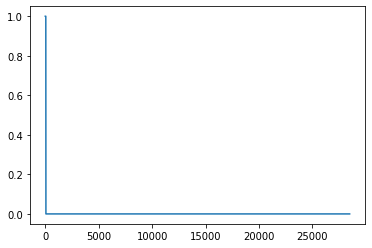

In [4]:
plt.plot(data['Class'])

In [5]:
fraud_count = data[data['Class'] == 1].count()['Class']
fraud_count

49

In [6]:
not_fraud_count = data[data['Class'] == 0].count()['Class']
not_fraud_count

28432

In [7]:
data.isnull().sum()[data.isnull().sum() > 0]

Series([], dtype: int64)

/home/soutobias/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'Amount'}>,
        <AxesSubplot:title={'center':'V1'}>]], dtype=object)

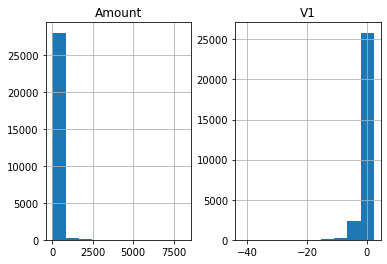

In [8]:
data[['Amount' , 'V1']].hist()

<AxesSubplot:>

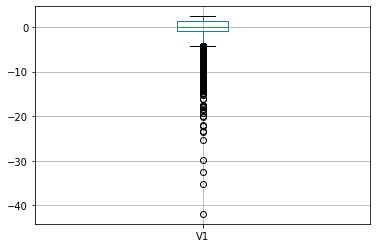

In [9]:
data[['V1']].boxplot()

In [10]:
X = data.drop(columns='Class')
y = data['Class']

In [12]:
r_scaler = RobustScaler()
r_scaler.fit(X[list(X.columns)])
X_scaled = r_scaler.transform(X[list(X.columns)])

In [13]:
model = LogisticRegression(max_iter=1000)
cv_results = cross_validate(model, X, y, cv=5)
base_score = cv_results['test_score'].mean()
base_score

0.9991573588405489

In [15]:
model = LogisticRegression(max_iter=1000)

# Predict class probabilties
data['prob_not_fraud'], data['prob_fraud'] =cross_val_predict(model,
                                                              X_scaled,
                                                              y,
                                                              cv=5,
                                                              method='predict_proba').T
# precision recall data
precision, recall, threshold = precision_recall_curve(y,
                                                      data['prob_fraud']) 

print(f'precision- {precision[:5]}')
print(f'recall- {recall[:5]}')
print(f'threshold- {threshold[:5]}')

precision- [0.00174216 0.00170667 0.00170673 0.00170679 0.00170685]
recall- [1.         0.97959184 0.97959184 0.97959184 0.97959184]
threshold- [2.74718135e-10 2.75096792e-10 2.75672435e-10 2.77939956e-10
 2.78260484e-10]


In [16]:
scores = pd.DataFrame({'threshold':threshold,
                       'precision': precision[:-1],
                       'recall':recall[:-1]})# Store in dataframe
scores.head()

,threshold,precision,recall
0,2.747181e-10,0.001742,1.000000
1,2.750968e-10,0.001707,0.979592
2,2.756724e-10,0.001707,0.979592
3,2.779400e-10,0.001707,0.979592
4,2.782605e-10,0.001707,0.979592


Text(0.5, 0, 'recall')

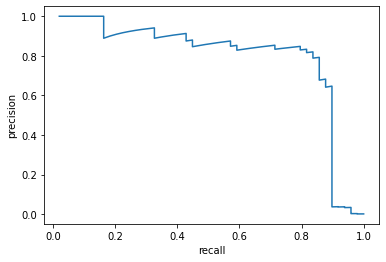

In [17]:
plt.plot(scores['recall'],scores['precision'])
plt.ylabel('precision')
plt.xlabel('recall')

In [19]:
new_threshold = scores[scores['precision'] >= 0.90].threshold.min()
new_threshold

0.9756708737415326

In [20]:
def custom_predict(X, custom_threshold):
    model.fit(X_scaled, y)
    probs = model.predict_proba(X) # Get likelihood of each sample being classified as 0 or 1
    y5_probs = probs[:, 1] # Only keep expensive likelihoods (1) 
    return (y5_probs > custom_threshold).astype(int) # Boolean outcome converted to 0 or 1

updated_preds = custom_predict(X_scaled, new_threshold) # Update predictions 

print(recall_score(y, updated_preds)) # Rerun recall
print(precision_score(y, updated_preds)) # Rerun precision
print(f1_score(y, updated_preds)) # Rerun f1

0.3877551020408163
0.95
0.5507246376811594


In [23]:
model = KNeighborsClassifier()
cv_results = cross_validate(model, X, y, cv=5)
base_knn_score = cv_results['test_score'].mean()
base_knn_score

0.998771104395572

In [24]:
# Predict class probabilties
data['prob_not_fraud'], data['prob_fraud'] =cross_val_predict(model,
                                                              X_scaled,
                                                              y,
                                                              cv=5,
                                                              method='predict_proba').T
# precision recall data
precision, recall, threshold = precision_recall_curve(y,
                                                      data['prob_fraud']) 

print(f'precision- {precision[:5]}')
print(f'recall- {recall[:5]}')
print(f'threshold- {threshold[:5]}')

precision- [0.00172045 0.71929825 0.79166667 0.86046512 0.94117647]
recall- [1.         0.83673469 0.7755102  0.75510204 0.65306122]
threshold- [0.  0.2 0.4 0.6 0.8]


In [25]:
scores = pd.DataFrame({'threshold':threshold,
                       'precision': precision[:-1],
                       'recall':recall[:-1]})# Store in dataframe
scores.head()

,threshold,precision,recall
0,0.0,0.001720,1.000000
1,0.2,0.719298,0.836735
2,0.4,0.791667,0.775510
3,0.6,0.860465,0.755102
4,0.8,0.941176,0.653061


Text(0.5, 0, 'recall')

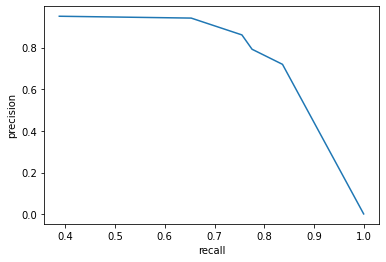

In [26]:
plt.plot(scores['recall'],scores['precision'])
plt.ylabel('precision')
plt.xlabel('recall')

In [28]:
new_threshold = scores[scores['precision'] >= 0.90].threshold.min()
new_threshold

0.8

In [29]:
updated_preds = custom_predict(X_scaled, new_threshold) # Update predictions 

print(recall_score(y, updated_preds)) # Rerun recall
print(precision_score(y, updated_preds)) # Rerun precision
print(f1_score(y, updated_preds)) # Rerun f1

0.5714285714285714
1.0
0.7272727272727273
